# MR to CT Translation with Diffusion Model

**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


# Preparing the dataset

In [2]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [3]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [73]:
# read mr and ct datasets
MR_train_address = 'drive/MyDrive/MR_CT_data/train_input.npy'
CT_train_address = 'drive/MyDrive/MR_CT_data/train_output.npy'

MR_val_address = 'drive/MyDrive/MR_CT_data/val_input.npy'
CT_val_address = 'drive/MyDrive/MR_CT_data/val_output.npy'

MR_test_address = 'drive/MyDrive/MR_CT_data/test_input.npy'
CT_test_address = 'drive/MyDrive/MR_CT_data/test_output.npy'

mr_train = np.load(MR_train_address)
ct_train = np.load(CT_train_address)

mr_val = np.load(MR_val_address)
ct_val = np.load(CT_val_address)

mr_test = np.load(MR_test_address)
ct_test = np.load(CT_test_address)

In [74]:
ct_train.shape, ct_val.shape, ct_test.shape

((570, 256, 256), (90, 256, 256), (150, 256, 256))

In [75]:
def convert_to_3channel(img):
  img = img.astype('float32')
  img_3channel = np.dstack((img, img, img))
  return img_3channel

In [76]:
# convert 1 channel mr and ct images to 3 channel for later processing
n_train_samples = ct_train.shape[0]
n_val_samples = ct_val.shape[0]
n_test_samples = ct_test.shape[0]

n_total_samples = n_train_samples + n_val_samples + n_test_samples

mr_total = [None] * n_total_samples
ct_total = [None] * n_total_samples


for i in range(n_train_samples):

  mr_total[i] = convert_to_3channel(mr_train[i])
  ct_total[i] = convert_to_3channel(ct_train[i])


for i in range(n_val_samples):

  j = i + n_train_samples

  mr_total[j] = convert_to_3channel(mr_val[i])
  ct_total[j] = convert_to_3channel(ct_val[i])


for i in range(n_test_samples):

  j = i + n_train_samples + n_val_samples

  mr_total[j] = convert_to_3channel(mr_test[i])
  ct_total[j] = convert_to_3channel(ct_test[i])


# convert lists of mr and ct to tensors
mr_total = np.array(mr_total)
mr_total = torch.tensor(mr_total)

ct_total = np.array(ct_total)
ct_total = torch.tensor(ct_total)

print('mr images shape:', mr_total[0].shape)
print('ct images shape:', ct_total[0].shape)

mr images shape: torch.Size([256, 256, 3])
ct images shape: torch.Size([256, 256, 3])


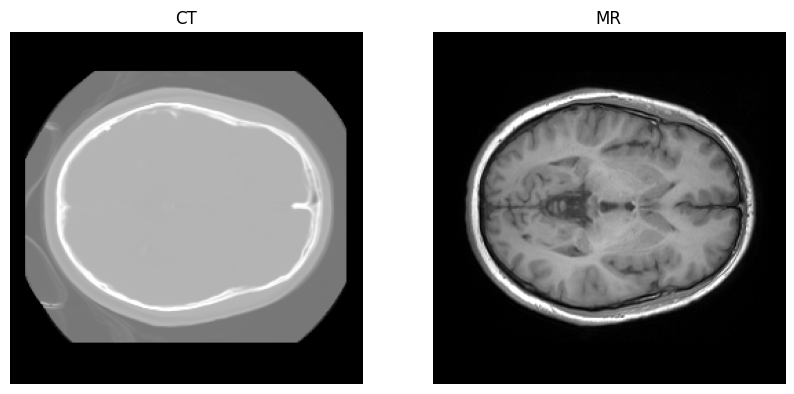

In [77]:
# show sapmles of 3 channel mr and ct
rows = 1
columns = 2
n_samples_to_show = 1

for i in range(n_samples_to_show):

  fig = plt.figure(figsize=(10, 10))

  fig.add_subplot(rows, columns, 1)

  plt.imshow(ct_total[i])
  plt.axis('off')
  plt.title('CT')

  fig.add_subplot(rows, columns, 2)

  plt.imshow(mr_total[i])
  plt.axis('off')
  plt.title('MR')
  plt.show

In [78]:
# create dataloaders
mr_dataset = TensorDataset(mr_total)
mr_dataloader = DataLoader(mr_dataset, batch_size=1, num_workers=2)

ct_dataset = TensorDataset(ct_total)
ct_dataloader = DataLoader(ct_dataset, batch_size=10, num_workers=2)

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [79]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 600
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

<ipython-input-80-3897b9276781>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


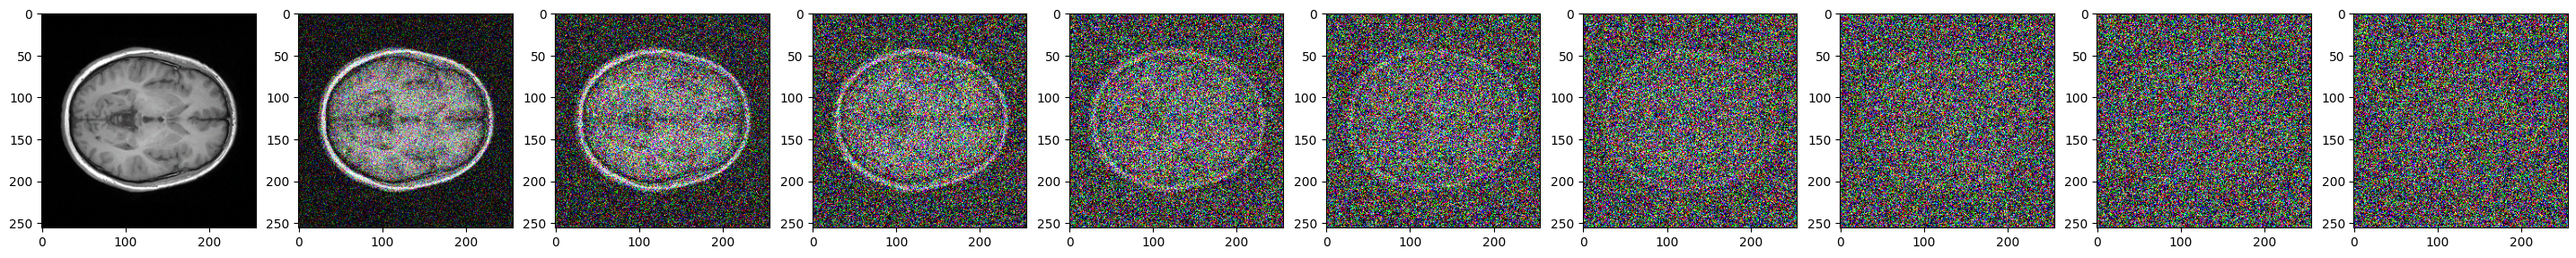

In [80]:
plt.figure(figsize=(40,40))
plt.axis('off')

num_images = 10
stepsize = int(T/num_images)
sample = mr_total[0]

for idx in range(0, T, stepsize):

    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    t = torch.Tensor([idx]).type(torch.int64)

    noisy_sample, noise = forward_diffusion_sample(sample, t)
    plt.imshow(noisy_sample)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [81]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        # down_channels = (64, 128, 256, 512, 1024)
        # up_channels = (1024, 512, 256, 128, 64)
        down_channels = (256, 256, 256, 512, 1024)
        up_channels = (1024, 512, 256, 256, 265)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  69048463


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Block(
      (time_mlp): Linear(in_features=32, out_features=512, bias=True)
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [82]:
def get_loss(model, x_0, t):

    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    x_noisy = x_noisy.permute(0, 3, 1, 2)
    noise = noise.permute(0, 3, 1, 2)

    noise_pred = model(x_noisy, t)

    return F.l1_loss(noise, noise_pred)

## Training

In [83]:
# from torch.optim import Adam

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
# optimizer = Adam(model.parameters(), lr=0.001)
# epochs = 100 # Try more!

# for epoch in range(epochs):
#     for step, batch in enumerate(dataloader):
#       optimizer.zero_grad()

#       t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
#       loss = get_loss(model, batch[0], t)
#       loss.backward()
#       optimizer.step()

#       if epoch % 5 == 0 and step == 0:
#         print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
#         sample_plot_image()

In [84]:
# epochs = 100 # Try more!
epochs = 10

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
  for step, ct_sample in enumerate(ct_dataloader):

    optimizer.zero_grad()

    ct_cuda = ct_sample[0].to(device)
    batch_size = ct_cuda.shape[0]

    t = torch.randint(0, T, (batch_size,), device=device).long()
    loss = get_loss(model, ct_cuda, t)

    # print(loss)

    loss.backward()
    optimizer.step()

    # if step == 0:
    #   break

    last_step = (n_total_samples/batch_size) - 1

    if step == last_step:
      print(f"Epoch {epoch} | Loss: {loss.item()} ")
      # sample_plot_image(noisy_mr)

Epoch 0 | Loss: 0.24294987320899963 
Epoch 1 | Loss: 0.10648033022880554 
Epoch 2 | Loss: 0.2029884159564972 
Epoch 3 | Loss: 0.19061188399791718 
Epoch 4 | Loss: 0.10433082282543182 
Epoch 5 | Loss: 0.08283648639917374 
Epoch 6 | Loss: 0.14268384873867035 
Epoch 7 | Loss: 0.08437985926866531 
Epoch 8 | Loss: 0.08046005666255951 
Epoch 9 | Loss: 0.11007507890462875 


##Helper funcions

In [85]:
# plot the output of the model
def reshape_tensor_to_plot(tensor):

  tensor = tensor.squeeze()
  tensor = tensor.detach().cpu().numpy()

  dim1 = tensor.shape[0]
  dim2 = tensor.shape[1]
  dim3 = tensor.shape[2]

  tensor = np.reshape(tensor, (dim3, dim2, dim1))

  return tensor
  # plt.imshow(tensor)
  # plt.show()

In [86]:
# change the dimonsion of the input image
# to be suitable for diffusion sampling (sample_plot_image function)
def prepare_for_diffusion_sample(img):

  dim1 = img.shape[0]
  dim2 = img.shape[1]
  dim3 = img.shape[2]

  reshaped_img = np.reshape(img, (dim3, dim2, dim1))
  reshaped_img = reshaped_img.unsqueeze(0)

  return reshaped_img

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [87]:
diffusion_outputs_path = f'drive/MyDrive/diffusion_outputs_T_{T}_epoch_{epochs}'
os.mkdir(diffusion_outputs_path)

In [88]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_save_diff_out(img):
    # Sample noise
    img_size = 256
    # img = torch.randn((1, 3, img_size, img_size), device=device)
    # plt.figure(figsize=(15,15))
    # plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
    #     # Edit: This is to maintain the natural range of the distribution
    #     img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
          # print(img.shape)
          diff_out = reshape_tensor_to_plot(img)

          diff_out_file_name = f'diff_out_{i}'
          diff_out_file_path = os.path.join(diffusion_outputs_path, diff_out_file_name)

          np.save(diff_out_file_path, diff_out)
            # plt.subplot(1, num_images, int(i/stepsize)+1)
    #         show_tensor_image(img.detach().cpu())
    # plt.show()

In [89]:
diffusion_step = 299
t = t = torch.full((1,), diffusion_step, device=device, dtype=torch.long)

mr_sample = mr_total[0]

noisy_mr, noise = forward_diffusion_sample(mr_sample, t)

noisy_mr = prepare_for_diffusion_sample(noisy_mr)
noisy_mr = noisy_mr.to(device)

# noisy_mr.is_cuda

sample_save_diff_out(noisy_mr)

In [16]:
T = 300
epochs = 10
diffusion_outputs_path = f'drive/MyDrive/diffusion_outputs_T_{T}_epoch_{epochs}'
diffusion_outputs_saved = os.listdir(diffusion_outputs_path)

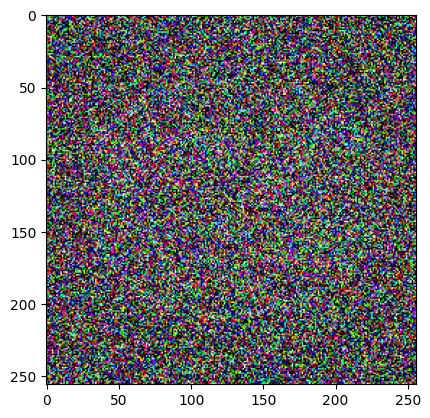

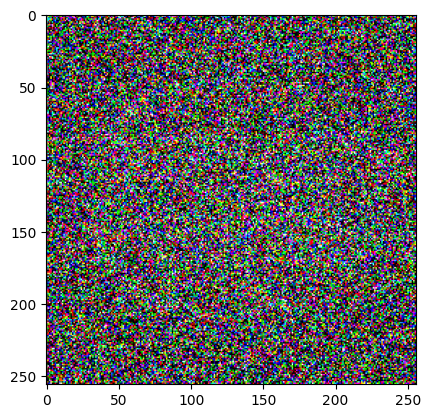

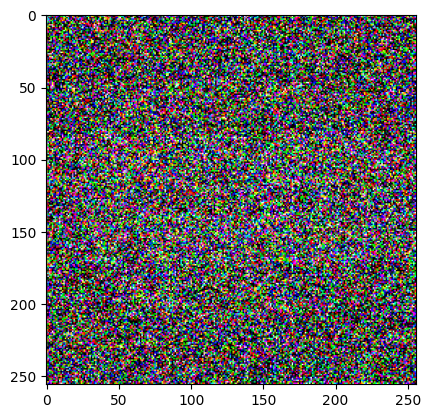

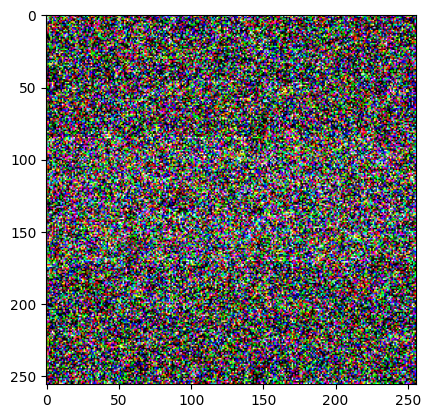

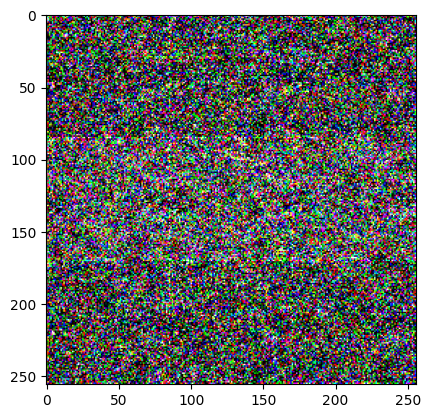

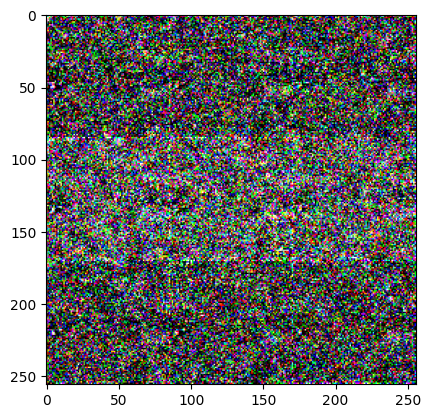

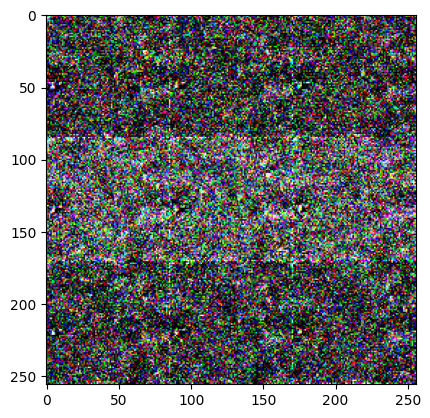

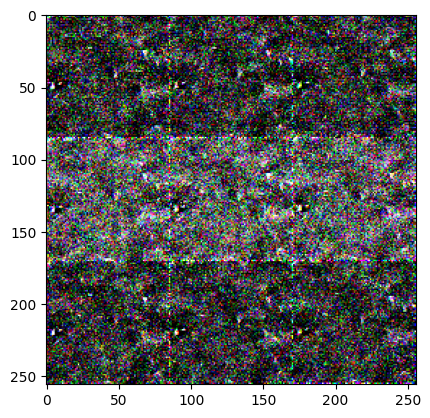

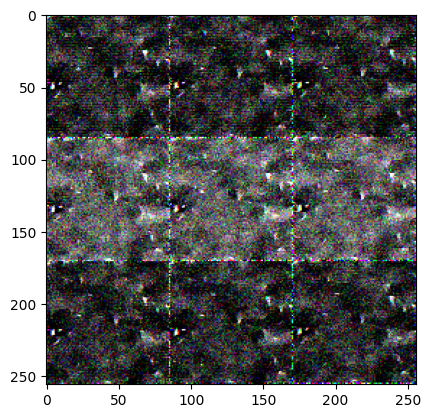

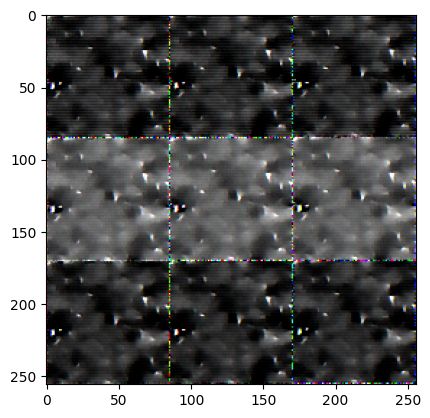

In [17]:
for file_name in diffusion_outputs_saved:
  file_address = os.path.join(diffusion_outputs_path, file_name)
  diff_out = np.load(file_address)
  # print(diff_out.shape)
  plt.imshow(diff_out)
  plt.show()

In [91]:
# n_diffusion_samples = len(diffusion_samples)
# diffusion_samples_np = [None] * n_diffusion_samples

# for i in range(n_diffusion_samples):

#   diffusion_sample = diffusion_samples[i]
#   diffusion_sample = reshape_to_show(diffusion_sample)

#   diffusion_samples_np[i] = diffusion_sample


# diffusion_samples_np = np.array(diffusion_samples_np)

# address = 'drive/MyDrive/diffusion_outputs/diffusion_samples_np.npy'
# np.save(address, diffusion_samples_np)

# for sample in diffusion_samples_np:

#   dim1 = sample.shape[0]
#   dim2 = sample.shape[1]
#   n_pixels = dim1 * dim2

#   flattened_sample = sample.flatten()
#   first_channel = flattened_sample[:n_pixels]

#   reshaped_sample = np.reshape(first_channel, (dim1, dim2))
#   plt.imshow(sample, cmap='bone')
#   plt.show()

In [92]:
# for sample in diffusion_samples_np:
#   plt.imshow(sample)
#   plt.show()